# 02 — Helmholtz Decomposition & QG Omega

Demonstrates on a real blocking event:

1. 3-D Helmholtz decomposition of anomalous winds → rotational / divergent / harmonic
2. QG omega equation solver
3. Moist / dry omega decomposition

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pvtend import helmholtz_decomposition, R_EARTH
from pvtend.helmholtz import helmholtz_decomposition_3d
from pvtend.omega import solve_qg_omega
from pvtend.moist_dry import decompose_omega

## 1  Load event data

In [2]:
DATA_ROOT = "/net/flood/data2/users/x_yan/tempest_extreme_4_basis/outputs_tmp"
d = dict(np.load(f"{DATA_ROOT}/blocking_tmp/onset/dh=+0/track_100_1992080507_dh+0.npz"))

lat = d["lat_vec"]
lon = d["lon_vec_unwrapped"]
levels = d["levels"]
X_rel, Y_rel = d["X_rel"], d["Y_rel"]
print(f"Grid: {lat.shape[0]}×{lon.shape[0]}, {len(levels)} levels")

Grid: 29×49, 9 levels


## 2  Helmholtz decomposition of anomalous wind

In [3]:
u_anom_3d = d["u_anom_3d"]   # (9, 29, 49)
v_anom_3d = d["v_anom_3d"]

result_3d = helmholtz_decomposition_3d(u_anom_3d, v_anom_3d, lat, lon, method="direct")
print("Helmholtz output keys:", sorted(result_3d.keys()))

Helmholtz output keys: ['chi', 'divergence', 'psi', 'u_div', 'u_har', 'u_rot', 'v_div', 'v_har', 'v_rot', 'vorticity']


In [4]:
# Compare with pre-computed NPZ values at 300 hPa
ilev = np.argmin(np.abs(levels - 300))

for comp in ["u_rot", "v_rot", "u_div", "v_div"]:
    npz_key = f"u_anom_{comp.split('_')[1]}_3d" if comp.startswith("u") else f"v_anom_{comp.split('_')[1]}_3d"
    computed = result_3d[comp][ilev]
    stored   = d[npz_key][ilev]
    relerr   = np.nanmean(np.abs(computed - stored)) / (np.nanmean(np.abs(stored)) + 1e-30)
    print(f"  {comp:6s}  rel-err = {relerr:.4e}")

  u_rot   rel-err = 3.4704e-01
  v_rot   rel-err = 6.3514e-01
  u_div   rel-err = 3.1532e-01
  v_div   rel-err = 7.1891e-01


## 3  Visualise rotational vs divergent wind at 300 hPa

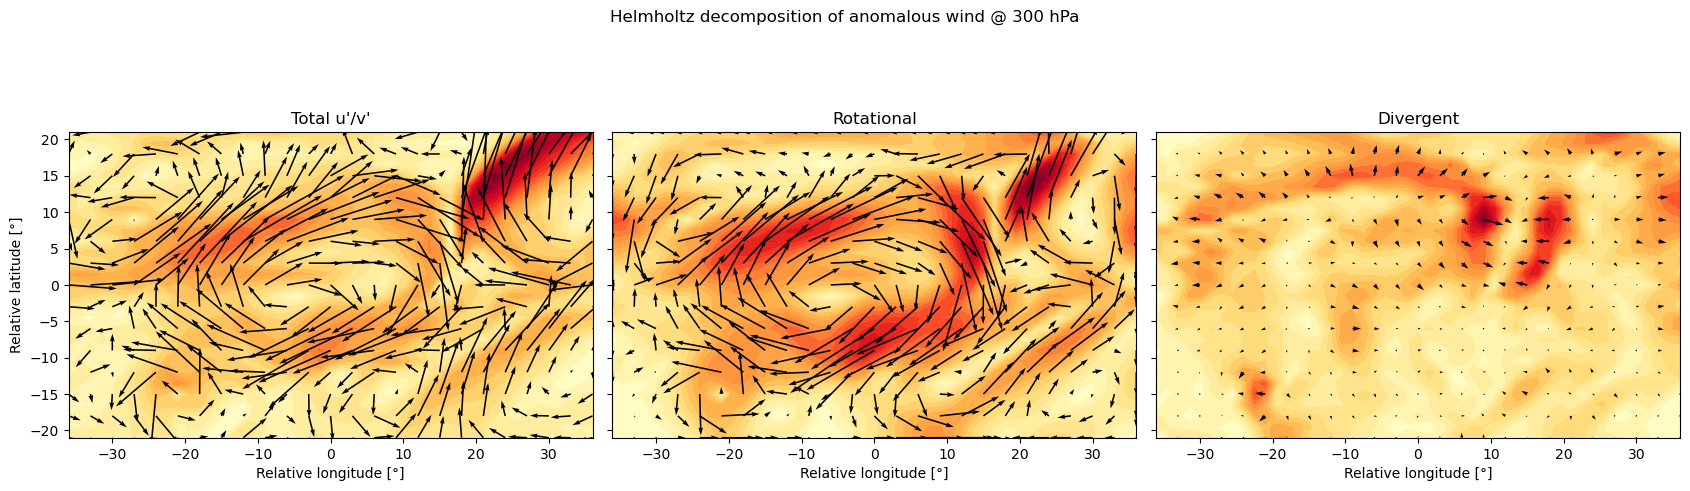

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(17, 5), sharey=True)
skip = 2
x, y = X_rel[0], Y_rel[:, 0]
xx, yy = np.meshgrid(x, y)

for ax, (title, uk, vk) in zip(axes, [
    ("Total u'/v'", u_anom_3d[ilev], v_anom_3d[ilev]),
    ("Rotational", result_3d["u_rot"][ilev], result_3d["v_rot"][ilev]),
    ("Divergent",  result_3d["u_div"][ilev], result_3d["v_div"][ilev]),
]):
    speed = np.sqrt(uk**2 + vk**2)
    ax.contourf(x, y, speed, levels=20, cmap="YlOrRd", extend="max")
    ax.quiver(xx[::skip, ::skip], yy[::skip, ::skip],
              uk[::skip, ::skip], vk[::skip, ::skip],
              scale=200, width=0.003, color="k")
    ax.set_title(title)
    ax.set_aspect("equal")

axes[0].set_ylabel("Relative latitude [°]")
for ax in axes:
    ax.set_xlabel("Relative longitude [°]")
fig.suptitle("Helmholtz decomposition of anomalous wind @ 300 hPa", y=1.02)
fig.tight_layout()
plt.show()

## 4  QG omega equation

In [6]:
u_3d = d["u_3d"]
v_3d = d["v_3d"]
t_3d = d["t_3d"]
plevs_pa = levels.astype(float) * 100.0

omega_dry_computed = solve_qg_omega(u_3d, v_3d, t_3d, lat, lon, plevs_pa)
omega_dry_stored   = d["omega_dry_3d"]

rel_err = np.nanmean(np.abs(omega_dry_computed[1:-1] - omega_dry_stored[1:-1])) / (
    np.nanmean(np.abs(omega_dry_stored[1:-1])) + 1e-30)
print(f"QG omega_dry  rel-err = {rel_err:.4e}")
print(f"omega_dry range: [{omega_dry_computed.min():.3e}, {omega_dry_computed.max():.3e}] Pa/s")

QG omega_dry  rel-err = 1.1004e+01
omega_dry range: [-3.253e+01, 3.494e+01] Pa/s


## 5  Omega cross-section through blocking centre

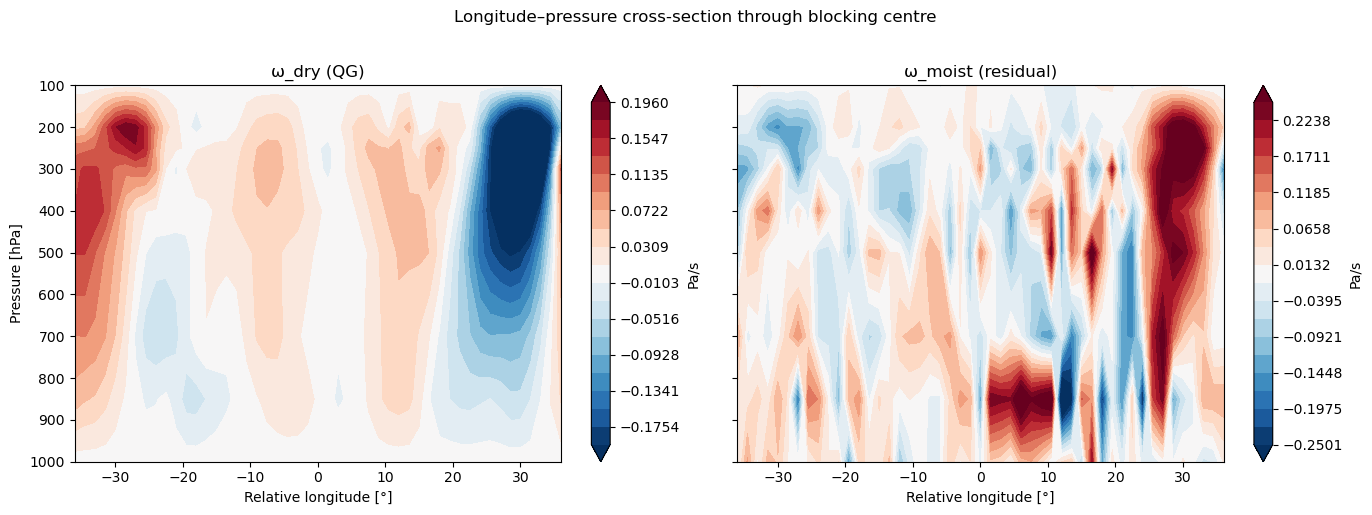

In [7]:
imid_lat = lat.shape[0] // 2  # centre row

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
omega_total_3d = d["w_3d"]  # total omega (Pa/s)

for ax, (title, omega) in zip(axes, [
    ("ω_dry (QG)", omega_dry_stored),
    ("ω_moist (residual)", d["omega_moist_3d"]),
]):
    vmax = np.nanpercentile(np.abs(omega[:, imid_lat, :]), 95)
    cf = ax.contourf(x, levels, omega[:, imid_lat, :],
                     levels=np.linspace(-vmax, vmax, 20), cmap="RdBu_r", extend="both")
    ax.set_title(title)
    ax.set_xlabel("Relative longitude [°]")
    plt.colorbar(cf, ax=ax, label="Pa/s")

axes[0].set_ylabel("Pressure [hPa]")
axes[0].invert_yaxis()
fig.suptitle("Longitude–pressure cross-section through blocking centre", y=1.02)
fig.tight_layout()
plt.show()

## 6  Moist–dry omega decomposition

In [8]:
omega_total = d["w_3d"]
omega_dry   = d["omega_dry_3d"]

decomp = decompose_omega(omega_total, omega_dry, lat, lon, plevs_pa,
                         u_div=result_3d["u_div"], v_div=result_3d["v_div"])
print("decompose_omega keys:", sorted(decomp.keys()))
print(f"omega_moist range: [{decomp['omega_moist'].min():.3e}, "
      f"{decomp['omega_moist'].max():.3e}] Pa/s")

decompose_omega keys: ['chi_moist', 'omega_moist', 'u_div_dry', 'u_div_moist', 'v_div_dry', 'v_div_moist']
omega_moist range: [-1.303e+00, 1.591e+00] Pa/s


## Summary

- **`helmholtz_decomposition_3d`** splits anomalous wind into rotational (ψ),
  divergent (χ) and harmonic components at every pressure level.
- **`solve_qg_omega`** solves the QG omega equation to isolate the adiabatic
  component of vertical motion.
- **`decompose_omega`** partitions ω into dry (QG) and moist (residual) parts,
  optionally computing the divergent-wind contribution of each.